# Задача: сегментация изображений (Rosneft Seismic Challenge)

В данной задаче используются материалы из конкурса Роснефти по анализу сейсмических данных. Выделение сейсмических горизонтов в кубе амплитуд.

Предстоит разработать алгоритм для выделения сейсмических горизонтов в кубе амплитуд, решить задачу сегментации данных с помощью распознавания изображений. 

Более подробно о данном конкурсе можно посмотреть [по ссылке](https://boosters.pro/championship/seismic_challenge/overview)

### Данные
* Исходный датасет представлен в двух видах:
    1.  Куб в сейсмическом формате SEG-Y, состоящий из набора 2-D срезов: кросслайнов и инлайнов
    2.  Срезы куба (кросслайны и инлайны), сохраненные в виде Grayscale-изображений
*  Количество классов сегментации: 8
*  В качестве обучающей выборки используется подкуб, составляющий 10% объёма исходного куба.
*  В качестве ответов к обучающей выборке используется .csv файл с масками закодированные в RLE

# Решение

Для задачи сегментации изображений будем использовать две нейросетевых архитектуры: FCN (Fully-Convolutional Network) и U-NET. Инструментарий, используемый для построения данных архитектур и обучения: Tensorflow, Keras.

Подгрузка необходимых библиотек:

In [1]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
import keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, Conv2DTranspose, Dropout
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, concatenate

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import cv2 
import os
import tqdm

from sklearn.model_selection import train_test_split
from collections import Counter

Определение путей к директориям с данными:

In [2]:
import pathlib
workdir = pathlib.Path().absolute()

IMAGE_PATH = f'{workdir}/make_rofneft_predict/data/train/images/'
MASK_PATH = f'{workdir}/make_rofneft_predict/data/train/train.csv'
TEST_PATH = f'{workdir}/make_rofneft_predict/data/test/images/'
SAMPLE_PATH = f'{workdir}/make_rofneft_predict/data/sample_submission.csv'

Функция кодирования RLE маски взята из конкурса AS IS:

In [3]:
def rle2mask(mask_rle, shape):
    """
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if mask_rle != mask_rle:
        return np.zeros_like(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

Класс загрузчика данных:

In [4]:
class TrainDataset():
    def __init__(self, image_dir, train):
        self.image_dir = image_dir
        self.train = train
        self.image_uses = []

    def __getitem__(self, index):
        
        
        img_name = self.train.iloc[index]['ImageId']
        if img_name in self.image_uses:
            return 'hups'
        else:
            self.image_uses.append(img_name)
            path = os.path.join(self.image_dir, img_name)
            img = cv2.imread(path)
            img = cv2.resize(img,(384,384))

            ce_mask = [
                (i + 1) * rle2mask(rle, shape=(img.shape[0], img.shape[1])) \
                    for i, rle in enumerate(self.train[self.train['ImageId']==img_name]['EncodedPixels'])
            ]
            ce_mask = np.sum(ce_mask, axis=0, dtype=np.float32)


            result = {
                'image':img, 
                'mask': ce_mask,
                'pick_name':img_name
            }
            return result
    
    def __len__(self, ):
        return len(self.train)

Загрузка тренировочного сета изображений (x_images - куб амплитуд, y_images - размеченные сейсмические горизонты для куба)

In [5]:
train = pd.read_csv(MASK_PATH)

train_dataset = TrainDataset(
    image_dir=IMAGE_PATH, 
    train=train)

In [6]:
x_images = []
y_images = []

for i in train_dataset:
    if type(i)==str:
        pass
    else:
        x_images.append(i['image'])
        y_images.append(i['mask']) 

Пример изображения куба амплитуд: 

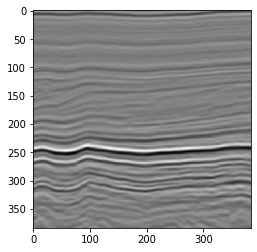

In [7]:
plt.imshow(x_images[0])

Cегментированное (размеченное) изображение его сейсмических горизонтов:

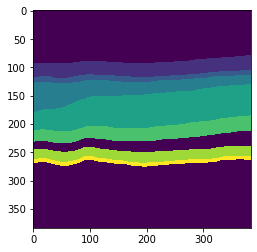

In [8]:
plt.imshow(y_images[0])

В данной задаче нет отдельных тренировочных, валидационных и тестовых датасетов. Поэтому, для обучения нейросети будем использовать один и тот же датасет, разделенный на тренировочную и тестовую части.

In [9]:
picture_model = np.reshape(np.array(x_images),(len(x_images),384,384,3))/255.
mask_model = np.array(y_images)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(picture_model, mask_model, test_size=0.10)

### Определение Baseline

Можем обратиться к сегментированным изображеним  и посчитать количество встречаемых пикселей для каждого из 8 классов сегментации:

In [11]:
Counter([item for jtem in y_images[0] for item in jtem])

Counter({0.0: 85556,
         1.0: 9499,
         2.0: 3385,
         3.0: 10263,
         4.0: 20315,
         5.0: 9134,
         6.0: 6736,
         7.0: 2568})

Для оценки качества алгоритма предлагается использоваться метрика dice по границе и всей области. Мы упростим задачу, оценивая dice по области.

Для этого необходимо реализовать следующую формулу:

\begin{equation}
dice = \sum_{k=0}^7(\cfrac{2*|prediction \cap truch|}{|prediction| + |truch|})
\end{equation}

Еще, чтобы не делить на ноль, потребуется добавить небольшой эпсилон к верхней и нижней части.

In [12]:
# вариант dice для софтмакса
def dice_metric_acc_v(y_true,y_pred):
    dices = []
    smooth = 1e-15
    outputs = tf.argmax(y_pred,axis=3)

    for val in range(0,8):
        target = tf.cast((y_true == val),'float32')
        output_step = tf.cast((outputs == val),'float32')
        intersection = tf.math.reduce_sum(output_step*target,axis=(1,2))
        union = tf.math.reduce_sum(output_step, axis=(1,2)) + tf.math.reduce_sum(target, axis=(1,2))      
        dice_part = (2 * intersection + smooth) / (union + smooth)

        dices.append(tf.math.reduce_mean(dice_part))
    return tf.reduce_mean(dices)

# и вариант, когда мы уже имеем классы
def dice_metric_base(y_true,y_pred):
    dices = []
    smooth = 1e-15
    outputs=y_pred

    for val in range(0,8):
        target = tf.cast((y_true == val),'float32')
        output_step = tf.cast((outputs == val),'float32')
        intersection = tf.math.reduce_sum(output_step*target,axis=(1,2))
        union = tf.math.reduce_sum(output_step, axis=(1,2)) + tf.math.reduce_sum(target, axis=(1,2))      
        dice_part = (2 * intersection + smooth) / (union + smooth)

        dices.append(tf.math.reduce_mean(dice_part))
    return tf.reduce_mean(dices)

Определяем baseline, который мы должны превзойти в своем алгоритме:

In [13]:
classes=[0,1,2,3,4,5,6,7]
dict_start={}
dict_end={}
dict_start
for ob_class in classes:
    dict_start[ob_class]=[]
    dict_end[ob_class]=[]
for y_trr in Y_train:
    first_col=y_trr[:,0]
    dict_start[0].append(0)
    for ob_class in classes:
        for i in range(1,len(first_col)):
            if first_col[i]==ob_class and first_col[i-1]!=ob_class:   
                dict_start[ob_class].append(i)
            elif first_col[i-1]==ob_class and first_col[i]!=ob_class:
                dict_end[ob_class].append(i)
                break

In [14]:
dict_total={}
for ob_class in classes:
    dict_total[ob_class]=[np.median(dict_start[ob_class]).astype(int),np.median(dict_end[ob_class]).astype(int)]

Text(0.5, 1.0, 'y_images_baseline')

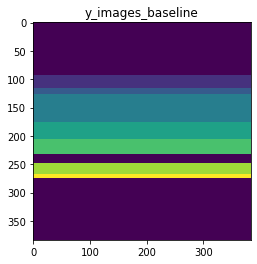

In [15]:
y_images_baseline=np.zeros(y_images[0].shape,dtype=int)
for ob_cl,bound in dict_total.items():
    y_images_baseline[bound[0]:bound[1],:]=ob_cl
plt.figure(figsize=(4,4))
plt.imshow(y_images_baseline)
plt.title("y_images_baseline")

Расчет метрик для baseline, используемых для валидации качества последующих моделей

In [16]:
y_images_baseline_vec=np.zeros(Y_test.shape,dtype=int)

for i in range(len(y_images_baseline_vec)):
    y_images_baseline_vec[i]=y_images_baseline
    
dice_metric_base(Y_test,y_images_baseline_vec)

<tf.Tensor: id=174, shape=(), dtype=float32, numpy=0.66477907>

Вывод: архитектура решения должна давать качество не ниже 0.665

### Настройка чекпойнтов для обучаемой нейросети

In [17]:
# сохраняет чекпойнты для лучшей модели (отдельный коллбек для UNET, отдельный для FCN) 
# мониторится метрика, вызываемая функцией val_dice_metric_acc_v, максимальное значение
save_model_unet = ModelCheckpoint('unet_small.h5',monitor='val_dice_metric_acc_v',save_best_only=True,mode='max')
save_model_fcn = ModelCheckpoint('fcn_small.h5',monitor='val_dice_metric_acc_v',save_best_only=True,mode='max')

# мониторится ранняя остановка обучения нейросети
# мониторится метрика, вызываемая функцией val_dice_metric_acc_v, максимальное значение (6 раз не достигла максимума)
stop_model = EarlyStopping(monitor='val_dice_metric_acc_v',mode='max',patience=6)

Using TensorFlow backend.


### Вариант решения на архитектуре FCN

In [24]:
TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS = x_images[0].shape[0:]

Для удобства выносим основные гиперпараметры в переменные. Ниже показаны значения оптимальных гиперпараметров, дающих лучшие показатели обучения нейросети. Данные значения достигнуты путем последовательного обучения архитектуры в течение нескольких десятков итераций.

In [150]:
FILTERS = 10
CNV = 3
LR = 2e-4

batch_size = 35
epochs = 500
validation_split=0.15

Архитектура представляет собой FCN. Сначала идет последовательное наращивание количества фильтров и сжатие через maxpooling. Затем идет последовательное уменьшение количества фильтров и распаковка посредством upsampling. Для обеспечения хороших результатов оказалось достаточным использование на каждом уровне двух конволюционных слоев. В конволюционных слоях спользуется активатор relu. После каждого конволюционного слоя используется нормализация батчей. Выходным слоем используется конволюционный слой из 8 фильтров (по количеству классов) и активатор  softmax. 

In [151]:
inputs = Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

down0 = Conv2D(FILTERS*1, (CNV, CNV), activation="relu", padding='same')(inputs)
down0 = BatchNormalization()(down0)
down0 = Conv2D(FILTERS*1, (CNV, CNV), activation="relu", padding='same')(down0)
down0 = BatchNormalization()(down0)
# down0 = Conv2D(FILTERS*1, (CNV, CNV), activation="relu", padding='same')(down0)
# down0 = BatchNormalization()(down0)
down0 = MaxPooling2D((2, 2), strides=(2, 2))(down0)

down1 = Conv2D(FILTERS*2, (CNV, CNV), activation="relu", padding='same')(down0)
down1 = BatchNormalization()(down1)
down1 = Conv2D(FILTERS*2, (CNV, CNV), activation="relu", padding='same')(down1)
down1 = BatchNormalization()(down1)
# down1 = Conv2D(FILTERS*2, (CNV, CNV), activation="relu", padding='same')(down1)
# down1 = BatchNormalization()(down1)
down1 = MaxPooling2D((2, 2), strides=(2, 2))(down1)

down2 = Conv2D(FILTERS*4, (CNV, CNV), activation="relu", padding='same')(down1)
down2 = BatchNormalization()(down2)
down2 = Conv2D(FILTERS*4, (CNV, CNV), activation="relu", padding='same')(down2)
down2 = BatchNormalization()(down2)
# down2 = Conv2D(FILTERS*4, (CNV, CNV), activation="relu", padding='same')(down2)
# down2 = BatchNormalization()(down2)
down2 = MaxPooling2D((2, 2), strides=(2, 2))(down2)

down3 = Conv2D(FILTERS*8, (CNV, CNV), activation="relu", padding='same')(down2)
down3 = BatchNormalization()(down3)
down3 = Conv2D(FILTERS*8, (CNV, CNV), activation="relu", padding='same')(down3)
down3 = BatchNormalization()(down3)
# down3 = Conv2D(FILTERS*8, (CNV, CNV), activation="relu", padding='same')(down3)
# down3 = BatchNormalization()(down3)
down3 = MaxPooling2D((2, 2), strides=(2, 2))(down3)

down4 = Conv2D(FILTERS*16, (CNV, CNV), activation="relu", padding='same')(down3)
down4 = BatchNormalization()(down4)
down4 = Conv2D(FILTERS*16, (CNV, CNV), activation="relu", padding='same')(down4)
down4 = BatchNormalization()(down4)
# down4 = Conv2D(FILTERS*16, (CNV, CNV), activation="relu", padding='same')(down4)
# down4 = BatchNormalization()(down4)
down4 = MaxPooling2D((2, 2), strides=(2, 2))(down4)

down5 = Conv2D(FILTERS*32, (CNV, CNV), activation="relu", padding='same')(down4)
down5 = BatchNormalization()(down5)
down5 = Conv2D(FILTERS*32, (CNV, CNV), activation="relu", padding='same')(down5)
down5 = BatchNormalization()(down5)
# down5 = Conv2D(FILTERS*32, (CNV, CNV), activation="relu", padding='same')(down5)
# down5 = BatchNormalization()(down5)
down5 = MaxPooling2D((2, 2), strides=(2, 2))(down5)

center = Conv2D(FILTERS*64, (CNV, CNV), activation="relu", padding='same')(down5)
center = BatchNormalization()(center)
center = Conv2D(FILTERS*64, (CNV, CNV), activation="relu", padding='same')(center)
center = BatchNormalization()(center)

up5 = UpSampling2D((2, 2))(center)
up5 = Conv2D(FILTERS*32, (CNV, CNV), activation="relu", padding='same')(up5)
up5 = BatchNormalization()(up5)
up5 = Conv2D(FILTERS*32, (CNV, CNV), activation="relu", padding='same')(up5)
up5 = BatchNormalization()(up5)
# up5 = Conv2D(FILTERS*32, (CNV, CNV), activation="relu", padding='same')(up5)
# up5 = BatchNormalization()(up5)

up4 = UpSampling2D((2, 2))(up5)
up4 = Conv2D(FILTERS*16, (CNV, CNV), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Conv2D(FILTERS*16, (CNV, CNV), activation="relu", padding='same')(up4)
up4 = BatchNormalization()(up4)
# up4 = Conv2D(FILTERS*16, (CNV, CNV), activation="relu", padding='same')(up4)
# up4 = BatchNormalization()(up4)

up3 = UpSampling2D((2, 2))(up4)
up3 = Conv2D(FILTERS*8, (CNV, CNV), activation="relu", padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Conv2D(FILTERS*8, (CNV, CNV), activation="relu", padding='same')(up3)
up3 = BatchNormalization()(up3)
# up3 = Conv2D(FILTERS*8, (CNV, CNV), activation="relu", padding='same')(up3)
# up3 = BatchNormalization()(up3)

up2 = UpSampling2D((2, 2))(up3)
up2 = Conv2D(FILTERS*4, (CNV, CNV), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Conv2D(FILTERS*4, (CNV, CNV), activation="relu", padding='same')(up2)
up2 = BatchNormalization()(up2)
# up2 = Conv2D(FILTERS*4, (CNV, CNV), activation="relu", padding='same')(up2)
# up2 = BatchNormalization()(up2)

up1 = UpSampling2D((2, 2))(up2)
up1 = Conv2D(FILTERS*2, (CNV, CNV), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Conv2D(FILTERS*2, (CNV, CNV), activation="relu", padding='same')(up1)
up1 = BatchNormalization()(up1)
# up1 = Conv2D(FILTERS*2, (CNV, CNV), activation="relu", padding='same')(up1)
# up1 = BatchNormalization()(up1)

up0 = UpSampling2D((2, 2))(up1)
up0 = Conv2D(FILTERS*1, (CNV, CNV), activation="relu", padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Conv2D(FILTERS*1, (CNV, CNV), activation="relu", padding='same')(up0)
up0 = BatchNormalization()(up0)
# up0 = Conv2D(FILTERS*1, (CNV, CNV), activation="relu", padding='same')(up0)
# up0 = BatchNormalization()(up0)

# 128
outputs = Conv2D(8, (1, 1),activation='softmax')(up0)
model_fully = Model(inputs=inputs, outputs=outputs)

Для обучения используем оптимизатор Adam. Выбор данного оптимизатора не подкреплен опытным путем. Данный оптимизатор лучше других справляется с выходом из локальных минимумов.  
В качестве функции потерь выбрана "sparse_categorical_crossentropy", подходит для задач сегментации изображений.
Метрика "dice" выбрана изначально как мера оценки качества модели.


In [152]:
optimizer = tf.optimizers.Adam(lr=LR)
# optimizer = tf.optimizers.RMSprop(lr=LR)
model_fully.compile(
    optimizer=optimizer, 
    loss="sparse_categorical_crossentropy", 
    metrics=["sparse_categorical_accuracy", dice_metric_acc_v]
)

In [153]:
with tf.device('/CPU:0'):
    history = model_fully.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks = [save_model_fcn, 
                                     stop_model, 
                                     ],
                        validation_split=validation_split,
                        shuffle=True,
                       )

Train on 685 samples, validate on 121 samples
Epoch 1/500
685/685 [==============================] - 769s 1s/sample - loss: 1.4874 - sparse_categorical_accuracy: 0.6238 - dice_metric_acc_v: 0.4768 - val_loss: 2.0044 - val_sparse_categorical_accuracy: 0.3556 - val_dice_metric_acc_v: 0.0665
Epoch 2/500
685/685 [==============================] - 726s 1s/sample - loss: 0.8653 - sparse_categorical_accuracy: 0.8762 - dice_metric_acc_v: 0.7122 - val_loss: 1.9781 - val_sparse_categorical_accuracy: 0.3804 - val_dice_metric_acc_v: 0.0695
Epoch 3/500
685/685 [==============================] - 724s 1s/sample - loss: 0.6921 - sparse_categorical_accuracy: 0.9243 - dice_metric_acc_v: 0.7876 - val_loss: 2.0061 - val_sparse_categorical_accuracy: 0.3888 - val_dice_metric_acc_v: 0.1031
Epoch 4/500
685/685 [==============================] - 714s 1s/sample - loss: 0.6135 - sparse_categorical_accuracy: 0.9426 - dice_metric_acc_v: 0.8668 - val_loss: 1.9765 - val_sparse_categorical_accuracy: 0.3912 - val_dice

Модель обучилась за 49 эпох с максимальным показателем метрики dice 0.98. Это очень высокий показатель похожести двух изображений.

График функции потерь на обучении и валидации представлен ниже:

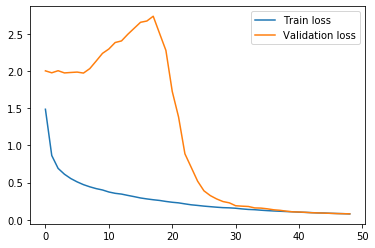

In [154]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

На графике виден ярко выраженный "взрыв" при валидации, но к 18 эпохе оптимизатор успешно справился со своей задачей и вышел из локального минимума. Затем к концу обучения плавно сравнялся с показателями функции потерь на обучении. В то время как функция потерь на обучении вела себя спокойно и плавно приближалась к 0 вплоть до 49 эпохи. 

Выполняем предсказание на тестовой подвыборке. Результатом будет максимальное значение по 3 оси.

In [155]:
with tf.device('/CPU:0'):
    pred_fully = model_fully.predict(X_test, verbose=0)

In [156]:
results_fully = tf.argmax(pred_fully, axis=3)

Сохраняем результаты в numpy массивы

In [157]:
np.save('pred_fully.npy', pred_fully)
np.save('results_fully.npy', results_fully)

Выводим сгенерированные изображения рядом с реальными, чтобы визуально определить степень их схожести.

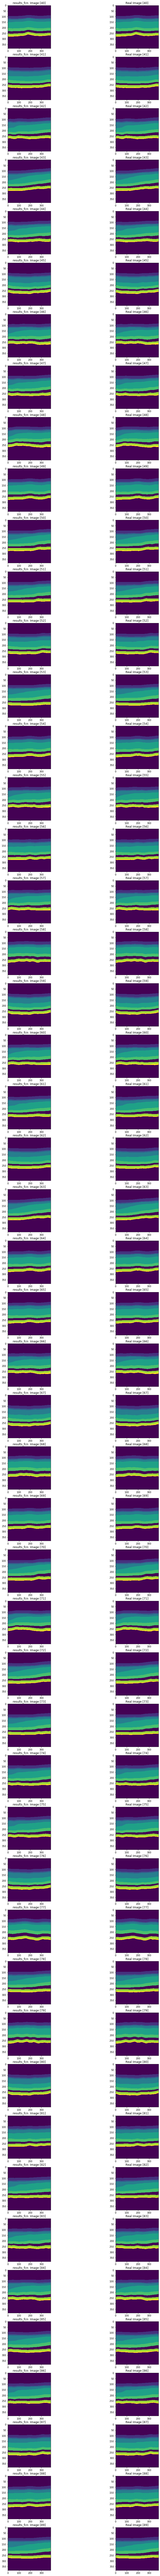

In [172]:
fig, axs = plt.subplots(50, 2, figsize=(15,200))
shift = 40
for i in range(0,50):
    axs[i, 0].imshow(results_fully[i+shift])
    axs[i, 0].set_title(f'results_fcn: Image [{i+shift}]')
    axs[i, 1].imshow(Y_test[i+shift])
    axs[i, 1].set_title(f'Real Image [{i+shift}]')
plt.show()

Сгенерированные изображения выглядят очень похоже с реальными. Форма и класс сегментированных срезов практически не отличаются от реальных.

### Вариант решения на архитектуре UNET

Снова выносим основные гиперпараметры в переменные. Ниже показаны значения оптимальных гиперпараметров, дающих лучшие показатели обучения нейросети. Данные значения достигнуты путем последовательного обучения архитектуры в течение нескольких десятков итераций.

In [92]:
FILTERS = 5
CNV1 = 3
CNV2 = 3
LR = 2e-4

batch_size = 35
epochs = 500
validation_split=0.15

Архитектура UNET отличается от предыдущей тем, информация о весах прокидывается с каждого уровня так называемого "сжатия" на каждый уровень "развертывания" и конкатенируется с весами, полученными после upsampling. Нормализация батчей не используется. Выходным слоем все также используется конволюционный слой из 8 фильтров (по количеству классов) и активатор  softmax. 

In [93]:
inputs = Input((TARGET_WIDTH , TARGET_HEIGHT, IMG_CHANNELS))

down0 = Conv2D(FILTERS*1, (CNV1, CNV2), activation="relu", padding='same')(inputs)
down0 = Conv2D(FILTERS*1, (CNV1, CNV2), activation="relu", padding='same')(down0)
down0 = MaxPooling2D((2, 2), strides=(2, 2))(down0)

down1 = Conv2D(FILTERS*2, (CNV1, CNV2), activation="relu", padding='same')(down0)
down1 = Conv2D(FILTERS*2, (CNV1, CNV2), activation="relu", padding='same')(down1)
down1 = MaxPooling2D((2, 2), strides=(2, 2))(down1)

down2 = Conv2D(FILTERS*4, (CNV1, CNV2), activation="relu", padding='same')(down1)
down2 = Conv2D(FILTERS*4, (CNV1, CNV2), activation="relu", padding='same')(down2)
down2 = MaxPooling2D((2, 2), strides=(2, 2))(down2)

down3 = Conv2D(FILTERS*8, (CNV1, CNV2), activation="relu", padding='same')(down2)
down3 = Conv2D(FILTERS*8, (CNV1, CNV2), activation="relu", padding='same')(down3)
down3 = MaxPooling2D((2, 2), strides=(2, 2))(down3)

down4 = Conv2D(FILTERS*16, (CNV1, CNV2), activation="relu", padding='same')(down3)
down4 = Conv2D(FILTERS*16, (CNV1, CNV2), activation="relu", padding='same')(down4)
down4 = MaxPooling2D((2, 2), strides=(2, 2))(down4)

down5 = Conv2D(FILTERS*32, (CNV1, CNV2), activation="relu", padding='same')(down4)
down5 = Conv2D(FILTERS*32, (CNV1, CNV2), activation="relu", padding='same')(down5)
down5 = MaxPooling2D((2, 2), strides=(2, 2))(down5)

center = Conv2D(FILTERS*64, (CNV1, CNV2), activation="relu", padding='same')(down5)
center = Conv2D(FILTERS*64, (CNV1, CNV2), activation="relu", padding='same')(center)

up5 = UpSampling2D((2, 2))(center)
up5 = concatenate([down4, up5], axis=3) 

up5 = Conv2D(FILTERS*32, (CNV1, CNV2), activation="relu", padding='same')(up5)
up5 = Conv2D(FILTERS*32, (CNV1, CNV2), activation="relu", padding='same')(up5)

up4 = UpSampling2D((2, 2))(up5)
up4 = concatenate([down3, up4], axis=3)  

up4 = Conv2D(FILTERS*16, (CNV1, CNV2), activation="relu", padding='same')(up4)
up4 = Conv2D(FILTERS*16, (CNV1, CNV2), activation="relu", padding='same')(up4)

up3 = UpSampling2D((2, 2))(up4)
up3 = concatenate([down2, up3], axis=3)   

up3 = Conv2D(FILTERS*8, (CNV1, CNV2), activation="relu", padding='same')(up3)
up3 = Conv2D(FILTERS*8, (CNV1, CNV2), activation="relu", padding='same')(up3)

up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down1, up2], axis=3)  

up2 = Conv2D(FILTERS*4, (CNV1, CNV2), activation="relu", padding='same')(up2)
up2 = Conv2D(FILTERS*4, (CNV1, CNV2), activation="relu", padding='same')(up2)

up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down0, up1], axis=3) 

up1 = Conv2D(FILTERS*2, (CNV1, CNV2), activation="relu", padding='same')(up1)
up1 = Conv2D(FILTERS*2, (CNV1, CNV2), activation="relu", padding='same')(up1)

up0 = UpSampling2D((2, 2))(up1)
up0 = Conv2D(FILTERS*1, (CNV1, CNV2), activation="relu", padding='same')(up0)
up0 = Conv2D(FILTERS*1, (CNV1, CNV2), activation="relu", padding='same')(up0)

# 128
outputs = Conv2D(8, (1, 1),activation='softmax')(up0)
model_unet = Model(inputs=inputs, outputs=outputs)

Оптимизатор, функцию потерь и метрику качества используем те же самые, здесь никаких изменений.

In [94]:
optimizer = tf.optimizers.Adam(lr=LR)
# optimizer = tf.optimizers.RMSprop(lr=LR)
model_unet.compile(
    optimizer=optimizer, 
    loss="sparse_categorical_crossentropy", 
    metrics=["sparse_categorical_accuracy", dice_metric_acc_v]
)

In [95]:
with tf.device('/CPU:0'):
    history = model_unet.fit(X_train, Y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks = [save_model_unet, stop_model,],
                        validation_split=validation_split,
                        shuffle=True,
                       )

Train on 685 samples, validate on 121 samples
Epoch 1/500
685/685 [==============================] - 292s 426ms/sample - loss: 2.0763 - sparse_categorical_accuracy: 0.5667 - dice_metric_acc_v: 0.0915 - val_loss: 2.0700 - val_sparse_categorical_accuracy: 0.4001 - val_dice_metric_acc_v: 0.0938
Epoch 2/500
685/685 [==============================] - 283s 414ms/sample - loss: 2.0259 - sparse_categorical_accuracy: 0.1036 - dice_metric_acc_v: 0.0283 - val_loss: 1.9531 - val_sparse_categorical_accuracy: 0.0705 - val_dice_metric_acc_v: 0.0188
Epoch 3/500
685/685 [==============================] - 289s 422ms/sample - loss: 1.6830 - sparse_categorical_accuracy: 0.1185 - dice_metric_acc_v: 0.0300 - val_loss: 1.2291 - val_sparse_categorical_accuracy: 0.5065 - val_dice_metric_acc_v: 0.0861
Epoch 4/500
685/685 [==============================] - 278s 406ms/sample - loss: 1.0493 - sparse_categorical_accuracy: 0.5680 - dice_metric_acc_v: 0.0909 - val_loss: 0.9965 - val_sparse_categorical_accuracy: 0.579

Epoch 34/500
685/685 [==============================] - 245s 358ms/sample - loss: 0.2023 - sparse_categorical_accuracy: 0.9396 - dice_metric_acc_v: 0.7841 - val_loss: 0.1989 - val_sparse_categorical_accuracy: 0.9412 - val_dice_metric_acc_v: 0.7857
Epoch 35/500
685/685 [==============================] - 245s 358ms/sample - loss: 0.1954 - sparse_categorical_accuracy: 0.9404 - dice_metric_acc_v: 0.7888 - val_loss: 0.2085 - val_sparse_categorical_accuracy: 0.9363 - val_dice_metric_acc_v: 0.7872
Epoch 36/500
685/685 [==============================] - 247s 360ms/sample - loss: 0.1968 - sparse_categorical_accuracy: 0.9391 - dice_metric_acc_v: 0.7872 - val_loss: 0.1839 - val_sparse_categorical_accuracy: 0.9417 - val_dice_metric_acc_v: 0.7925
Epoch 37/500
685/685 [==============================] - 246s 359ms/sample - loss: 0.1772 - sparse_categorical_accuracy: 0.9429 - dice_metric_acc_v: 0.7936 - val_loss: 0.1745 - val_sparse_categorical_accuracy: 0.9426 - val_dice_metric_acc_v: 0.7921
Epoch 38

685/685 [==============================] - 246s 359ms/sample - loss: 0.1080 - sparse_categorical_accuracy: 0.9551 - dice_metric_acc_v: 0.8262 - val_loss: 0.1082 - val_sparse_categorical_accuracy: 0.9540 - val_dice_metric_acc_v: 0.8252
Epoch 68/500
685/685 [==============================] - 246s 359ms/sample - loss: 0.1072 - sparse_categorical_accuracy: 0.9551 - dice_metric_acc_v: 0.8267 - val_loss: 0.1059 - val_sparse_categorical_accuracy: 0.9562 - val_dice_metric_acc_v: 0.8279
Epoch 69/500
685/685 [==============================] - 245s 358ms/sample - loss: 0.1103 - sparse_categorical_accuracy: 0.9545 - dice_metric_acc_v: 0.8255 - val_loss: 0.1083 - val_sparse_categorical_accuracy: 0.9547 - val_dice_metric_acc_v: 0.8266
Epoch 70/500
685/685 [==============================] - 245s 358ms/sample - loss: 0.1073 - sparse_categorical_accuracy: 0.9549 - dice_metric_acc_v: 0.8263 - val_loss: 0.1071 - val_sparse_categorical_accuracy: 0.9560 - val_dice_metric_acc_v: 0.8260
Epoch 71/500
685/685 

Модель обучилась за 114 эпох с максимальным показателем метрики dice 0.95. Это очень высокий показатель похожести двух изображений.

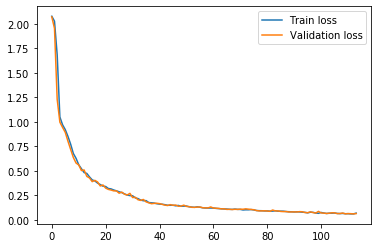

In [96]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

На графике нет "взрыва" при валидации, как при использовании архитектуры FCN. Оптимизатор успешно справился со своей задачей. На протяжении всего обучения обучение проходит плавно. Функции потерь на валидации и обучении практически идентичны. 

Выполняем предсказание на тестовой подвыборке. Результатом будет максимальное значение по 3 оси.

In [97]:
with tf.device('/CPU:0'):
    pred_unet = model_unet.predict(X_test, verbose=0)

In [98]:
results_unet = tf.argmax(pred_unet,axis=3)

Сохраняем результаты в numpy массивы

In [99]:
np.save('pred_unet.npy', pred_unet)
np.save('results_unet.npy', results_unet)

Выводим сгенерированные изображения рядом с реальными, чтобы визуально определить степень их схожести.

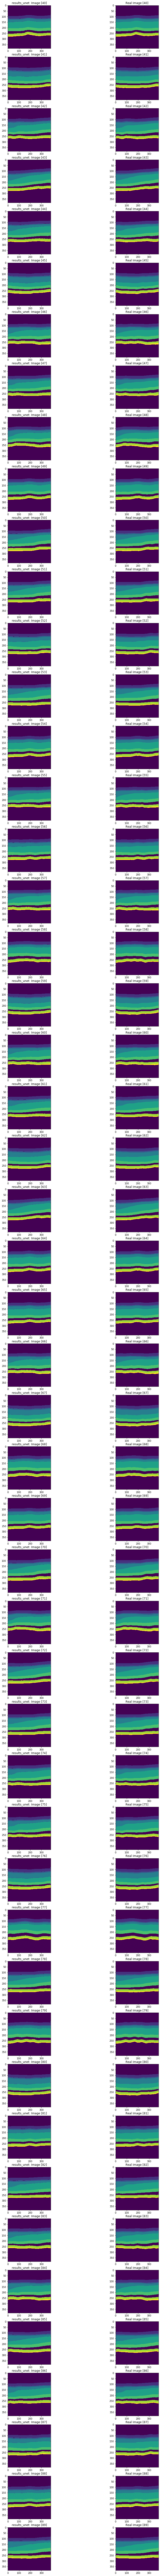

In [160]:
fig, axs = plt.subplots(50, 2, figsize=(15,200))
shift = 40
for i in range(0,50):
    axs[i, 0].imshow(results_unet[i+shift])
    axs[i, 0].set_title(f'results_unet: Image [{i+shift}]')
    axs[i, 1].imshow(Y_test[i+shift])
    axs[i, 1].set_title(f'Real Image [{i+shift}]')
plt.show()

Сгенерированные изображения выглядят очень похоже с реальными. Форма и класс сегментированных срезов практически не отличаются от реальных.

### ВЫВОДЫ

На используемых архитектурах достигнуты практически идеальные показатели DICE: 0.98 и 0.95.
Модель FCN обучилась за вдвое меньшее количество эпох и дала лучший результат. Следовательно, для решения подобных задач сегментации изображений целесообразно использовать данную архитектуру.

Однако, на UNET обучение проходит более плавно и спокойно. И есть смысл пожертвовать сравнительно небольшой разницей в качестве, но взамен получать гарантированное успешное обучение без "взрывов" или "затуханий" градиента.